In [13]:
# Importuri necesare
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from dateutil.relativedelta import relativedelta
import warnings
import pickle
from sklearn.preprocessing import LabelEncoder

warnings.filterwarnings('ignore')

# Setări vizualizare
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10

In [14]:
# Încărcarea datelor

df_complet = pd.read_excel("date_lunare.xlsx")
df_agregat = pd.read_excel("date_agregat.xlsx")

print(f"\n Dataset complet:")
print(f"Dimensiune: {df_complet.shape}")
print(f"Perioada: {df_complet['An'].min()}-{df_complet['Luna'].min():02d} la {df_complet['An'].max()}-{df_complet['Luna'].max():02d}")
print(f"Țări unice: {df_complet['Tara'].nunique()}")
print(f"Scopuri unice: {df_complet['Scop'].nunique()}")
print(f"Total imigranti: {df_complet['Numar'].sum():,}")

print(f"\n Dataset agregat:")
print(f"Dimensiune: {df_agregat.shape}")
print(f"Scopuri unice: {df_agregat['Scop'].nunique()}")


 Dataset complet:
Dimensiune: (82870, 5)
Perioada: 2018-01 la 2025-12
Țări unice: 172
Scopuri unice: 12
Total imigranti: 42,409

 Dataset agregat:
Dimensiune: (999, 4)
Scopuri unice: 12


In [17]:
# Identifică și analizează lunile lipsă din dataset
def analyze_missing_months(df):
    
    # Identifică toate lunile existente
    luni_existente = df[['An', 'Luna']].drop_duplicates().sort_values(['An', 'Luna'])
    print(f"\n Luni cu date: {len(luni_existente)}")
    
    # Creează lista completă de luni așteptate
    min_an, min_luna = df['An'].min(), df['Luna'].min()
    max_an, max_luna = df['An'].max(), df['Luna'].max()
    
    data_start = datetime(min_an, min_luna, 1)
    data_end = datetime(max_an, max_luna, 1)
    
    # Generează toate lunile din interval
    luni_asteptate = []
    data_curenta = data_start
    while data_curenta <= data_end:
        luni_asteptate.append((data_curenta.year, data_curenta.month))
        data_curenta += relativedelta(months=1)
    
    print(f" Luni așteptate în interval: {len(luni_asteptate)}")
    
    # Identifică lunile lipsă
    luni_existente_set = set(zip(luni_existente['An'], luni_existente['Luna']))
    luni_lipsa = [luna for luna in luni_asteptate if luna not in luni_existente_set]
    
    if luni_lipsa:
        print(f"\nLUNI LIPSĂ: {len(luni_lipsa)}")
        luni_nume = ['Ianuarie', 'Februarie', 'Martie', 'Aprilie', 'Mai', 'Iunie',
                     'Iulie', 'August', 'Septembrie', 'Octombrie', 'Noiembrie', 'Decembrie']
        
        # Grupează pe ani
        luni_lipsa_pe_an = {}
        for an, luna in luni_lipsa:
            if an not in luni_lipsa_pe_an:
                luni_lipsa_pe_an[an] = []
            luni_lipsa_pe_an[an].append(luna)
        
        for an in sorted(luni_lipsa_pe_an.keys()):
            print(f"\n   {an}:")
            for luna in sorted(luni_lipsa_pe_an[an]):
                print(f"      - {luni_nume[luna-1]} ({an}-{luna:02d})")
    else:
        print("\n Date complete - nu există luni lipsă!")
    
    return luni_lipsa


print("Verificare dataset complet:")
luni_lipsa_c = analyze_missing_months(df_complet)
print("\nVerificare dataset agregat:")
luni_lipsa_a = analyze_missing_months(df_agregat)



Verificare dataset complet:

 Luni cu date: 91
 Luni așteptate în interval: 96

LUNI LIPSĂ: 5

   2019:
      - Aprilie (2019-04)
      - August (2019-08)

   2024:
      - Iulie (2024-07)

   2025:
      - Noiembrie (2025-11)
      - Decembrie (2025-12)

Verificare dataset agregat:

 Luni cu date: 91
 Luni așteptate în interval: 96

LUNI LIPSĂ: 5

   2019:
      - Aprilie (2019-04)
      - August (2019-08)

   2024:
      - Iulie (2024-07)

   2025:
      - Noiembrie (2025-11)
      - Decembrie (2025-12)


In [21]:
def complete_missing_months_complet(df, luni_de_completat=None):
   
    df_complet_final = df.copy()
    
    if luni_de_completat is None or not luni_de_completat:
        print("\n✓ Nu există luni de completat pentru dataset complet")
        return df_complet_final
    
    print(f"\nDataset COMPLET - Luni de completat: {len(luni_de_completat)}")
    
    for an_lipsa, luna_lipsa in luni_de_completat:
        print(f"\n   Completare {an_lipsa}-{luna_lipsa:02d}...")
        
        # Găsește toate combinațiile unice de (Țară, Scop)
        combinatii = df[['Tara', 'Scop']].drop_duplicates()
        
        inregistrari_noi = []
        
        for _, row in combinatii.iterrows():
            tara = row['Tara']
            scop = row['Scop']
            
            # Găsește toate valorile pentru aceeași lună din alți ani
            valori_aceeasi_luna = df[
                (df['Tara'] == tara) & 
                (df['Scop'] == scop) & 
                (df['Luna'] == luna_lipsa) &
                (df['An'] != an_lipsa)  # Din alți ani
            ]['Numar']
            
            if len(valori_aceeasi_luna) > 0:
                # Calculează media
                valoare_estimata = int(valori_aceeasi_luna.mean())
                
                # Doar dacă valoarea estimată > 0
                if valoare_estimata > 0:
                    inregistrari_noi.append({
                        'An': an_lipsa,
                        'Luna': luna_lipsa,
                        'Tara': tara,
                        'Scop': scop,
                        'Numar': valoare_estimata
                    })
        
        print(f"      → Înregistrări noi: {len(inregistrari_noi)}")
        
        # Adaugă înregistrările noi
        if inregistrari_noi:
            df_nou = pd.DataFrame(inregistrari_noi)
            df_complet_final = pd.concat([df_complet_final, df_nou], ignore_index=True)
    
    # Sortează
    df_complet_final = df_complet_final.sort_values(['An', 'Luna', 'Tara', 'Scop']).reset_index(drop=True)
    
    return df_complet_final




In [23]:
print(f"Date înainte: {len(df_complet):,} înregistrări, {df_complet[['An', 'Luna']].drop_duplicates().shape[0]} luni unice")

df_complet_completat = complete_missing_months_complet(df_complet, luni_lipsa_c)

print(f"\nDate după: {len(df_complet_completat):,} înregistrări, {df_complet_completat[['An', 'Luna']].drop_duplicates().shape[0]} luni unice")


Date înainte: 82,870 înregistrări, 91 luni unice

Dataset COMPLET - Luni de completat: 5

   Completare 2019-04...
      → Înregistrări noi: 59

   Completare 2019-08...
      → Înregistrări noi: 84

   Completare 2024-07...
      → Înregistrări noi: 73

   Completare 2025-11...
      → Înregistrări noi: 84

   Completare 2025-12...
      → Înregistrări noi: 77

Date după: 83,247 înregistrări, 96 luni unice


In [19]:
def complete_missing_months_agregat(df, luni_de_completat=None):
  
    df_agregat_final = df.copy()
    
    if luni_de_completat is None or not luni_de_completat:
        print("\n✓ Nu există luni de completat pentru dataset agregat")
        return df_agregat_final
    
    print(f"\n Dataset AGREGAT - Luni de completat: {len(luni_de_completat)}")
    
    for an_lipsa, luna_lipsa in luni_de_completat:
        print(f"\n   Completare {an_lipsa}-{luna_lipsa:02d}...")
        
        # Găsește toate scopurile unice
        scopuri = df['Scop'].unique()
        
        inregistrari_noi = []
        
        for scop in scopuri:
            # Găsește toate valorile pentru aceeași lună din alți ani
            valori_aceeasi_luna = df[
                (df['Scop'] == scop) & 
                (df['Luna'] == luna_lipsa) &
                (df['An'] != an_lipsa)  # Din alți ani
            ]['Numar']
            
            if len(valori_aceeasi_luna) > 0:
                # Calculează media
                valoare_estimata = int(valori_aceeasi_luna.mean())
                
                # Doar dacă valoarea estimată > 0
                if valoare_estimata > 0:
                    inregistrari_noi.append({
                        'An': an_lipsa,
                        'Luna': luna_lipsa,
                        'Scop': scop,
                        'Numar': valoare_estimata
                    })
        
        print(f"      → Înregistrări noi: {len(inregistrari_noi)}")
        
        # Adaugă înregistrările noi
        if inregistrari_noi:
            df_nou = pd.DataFrame(inregistrari_noi)
            df_agregat_final = pd.concat([df_agregat_final, df_nou], ignore_index=True)
    
    # Sortează
    df_agregat_final = df_agregat_final.sort_values(['An', 'Luna', 'Scop']).reset_index(drop=True)
    
    return df_agregat_final

In [24]:
print(f"Date înainte: {len(df_agregat):,} înregistrări, {df_agregat[['An', 'Luna']].drop_duplicates().shape[0]} luni unice")

df_agregat_completat = complete_missing_months_agregat(df_agregat, luni_lipsa_a)

print(f"\nDate după: {len(df_agregat_completat):,} înregistrări, {df_agregat_completat[['An', 'Luna']].drop_duplicates().shape[0]} luni unice")


Date înainte: 999 înregistrări, 91 luni unice

 Dataset AGREGAT - Luni de completat: 5

   Completare 2019-04...
      → Înregistrări noi: 8

   Completare 2019-08...
      → Înregistrări noi: 8

   Completare 2024-07...
      → Înregistrări noi: 7

   Completare 2025-11...
      → Înregistrări noi: 7

   Completare 2025-12...
      → Înregistrări noi: 8

Date după: 1,037 înregistrări, 96 luni unice


In [25]:
def verify_completion(df, luni_completate, dataset_name="Dataset"):
    
    if not luni_completate:
        print(f"\n {dataset_name}: Nu există luni completate")
        return
    
    print(f" {dataset_name}")
    
    luni_existente_nou = set(zip(df['An'], df['Luna']))
    
    print("\n✓ Status luni completate:")
    for an, luna in luni_completate:
        status = "ok" if (an, luna) in luni_existente_nou else "erorr"
        total_imigranti = df[(df['An'] == an) & (df['Luna'] == luna)]['Numar'].sum()
        print(f"   {status} {an}-{luna:02d}: {total_imigranti:,} imigranti (estimat)")
    
    # Comparație cu lunile adiacente
    print("\n Comparație cu lunile adiacente:")
    
    for an, luna in luni_completate:
        # Luna anterioară
        if luna > 1:
            luna_ant = luna - 1
            an_ant = an
        else:
            luna_ant = 12
            an_ant = an - 1
        
        # Luna următoare
        if luna < 12:
            luna_urm = luna + 1
            an_urm = an
        else:
            luna_urm = 1
            an_urm = an + 1
        
        val_ant = df[(df['An'] == an_ant) & (df['Luna'] == luna_ant)]['Numar'].sum()
        val_curenta = df[(df['An'] == an) & (df['Luna'] == luna)]['Numar'].sum()
        val_urm = df[(df['An'] == an_urm) & (df['Luna'] == luna_urm)]['Numar'].sum()
        
        print(f"\n   {an}-{luna:02d}:")
        print(f"      Anterioară ({an_ant}-{luna_ant:02d}): {val_ant:6,}")
        print(f"      Estimată   ({an}-{luna:02d}):      {val_curenta:6,} ⬅")
        print(f"      Următoare ({an_urm}-{luna_urm:02d}): {val_urm:6,}")

# Verifică ambele dataset-uri
print("\n Verificare dataset COMPLET:")
verify_completion(df_complet_completat, luni_lipsa_c, "Dataset Complet (cu țări)")

print("\n Verificare dataset AGREGAT:")
verify_completion(df_agregat_completat, luni_lipsa_a, "Dataset Agregat (fără țări)")



 Verificare dataset COMPLET:
 Dataset Complet (cu țări)

✓ Status luni completate:
   ok 2019-04: 302 imigranti (estimat)
   ok 2019-08: 460 imigranti (estimat)
   ok 2024-07: 391 imigranti (estimat)
   ok 2025-11: 541 imigranti (estimat)
   ok 2025-12: 616 imigranti (estimat)

 Comparație cu lunile adiacente:

   2019-04:
      Anterioară (2019-03):    408
      Estimată   (2019-04):         302 ⬅
      Următoare (2019-05):    686

   2019-08:
      Anterioară (2019-07):    412
      Estimată   (2019-08):         460 ⬅
      Următoare (2019-09):    733

   2024-07:
      Anterioară (2024-06):    422
      Estimată   (2024-07):         391 ⬅
      Următoare (2024-08):    999

   2025-11:
      Anterioară (2025-10):    791
      Estimată   (2025-11):         541 ⬅
      Următoare (2025-12):    616

   2025-12:
      Anterioară (2025-11):    541
      Estimată   (2025-12):         616 ⬅
      Următoare (2026-01):      0

 Verificare dataset AGREGAT:
 Dataset Agregat (fără țări)

✓ Statu

In [26]:
#Explorarea structurii datelor
print("STRUCTURA DATASET COMPLET")
print(df_complet_completat.info())
print(df_agregat_completat.info())


print("PRIMELE 10 ÎNREGISTRĂRI")
print(df_complet_completat.head(5))
print(df_agregat_completat.head(5))


print("STATISTICI DESCRIPTIVE")
print(df_complet_completat.describe())
print(df_agregat_completat.describe())

STRUCTURA DATASET COMPLET
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83247 entries, 0 to 83246
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   An      83247 non-null  int64 
 1   Luna    83247 non-null  int64 
 2   Tara    83247 non-null  object
 3   Scop    83247 non-null  object
 4   Numar   83247 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 3.2+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1037 entries, 0 to 1036
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   An      1037 non-null   int64 
 1   Luna    1037 non-null   int64 
 2   Scop    1037 non-null   object
 3   Numar   1037 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 32.5+ KB
None
PRIMELE 10 ÎNREGISTRĂRI
     An  Luna           Tara  \
0  2018     1  AFRICA DE SUD   
1  2018     1  AFRICA DE SUD   
2  2018     1  AFRICA DE SUD   
3  2018     1  AFRICA DE SUD 

In [27]:
# Verificarea calității datelor

def verify_data_quality(df, dataset_name="Dataset"):

    # Valori lipsă
    print("\n1. Valori lipsă:")
    missing = df.isnull().sum()
    print(missing[missing > 0] if missing.sum() > 0 else "Nu există valori lipsă")

    # Duplicate
    duplicates = df.duplicated().sum()
    print(f"\n2. Rânduri duplicate: {duplicates}")

    # Valori negative
    negative = (df['Numar'] < 0).sum()
    print(f"\n3. Valori negative: {negative}")

    # Verificare continuitate temporală
    print("\n4. Continuitate temporală:")
    months_unique = df[['An', 'Luna']].drop_duplicates().sort_values(['An', 'Luna'])
    print(f"  - Luni cu date: {len(months_unique)}")

    # Identifică luni lipsă
    all_months = []
    for year in range(df['An'].min(), df['An'].max() + 1):
        for month in range(1, 13):
            if year == df['An'].min() and month < df['Luna'].min():
                continue
            if year == df['An'].max() and month > df['Luna'].max():
                continue
            all_months.append((year, month))

    existing = set(zip(months_unique['An'], months_unique['Luna']))
    missing_months = [m for m in all_months if m not in existing]

    if missing_months:
        print(f"Luni lipsă: {len(missing_months)}")
        for y, m in missing_months[:5]:  # Afișează primele 5
            print(f"    - {y}-{m:02d}")
    else:
        print("Nu există luni lipsă")



print("\nVerificare dataset COMPLET:")
verify_data_quality(df_complet_completat, "Dataset Complet (cu țări)")

print("\nVerificare dataset AGREGAT:")
verify_data_quality(df_agregat_completat, "Dataset Agregat (fără țări)")



Verificare dataset COMPLET:

1. Valori lipsă:
Nu există valori lipsă

2. Rânduri duplicate: 0

3. Valori negative: 0

4. Continuitate temporală:
  - Luni cu date: 96
Nu există luni lipsă

Verificare dataset AGREGAT:

1. Valori lipsă:
Nu există valori lipsă

2. Rânduri duplicate: 0

3. Valori negative: 0

4. Continuitate temporală:
  - Luni cu date: 96
Nu există luni lipsă



Total scopuri: 12

Distribuție pe scopuri:
 1. Imigrare la munca                             | Total: 18,767.0 | Procent:  42.0%
 2. Reintregirea familiei                         | Total: 15,460.0 | Procent:  34.6%
 3. La studii                                     | Total: 5,390.0 | Procent:  12.1%
 4. Activitati religioase, umanitare si de voluntariat | Total: 2,135.0 | Procent:   4.8%
 5. Alte cazuri                                   | Total: 1,911.0 | Procent:   4.3%
 6. Investitii straine                            | Total:   706.0 | Procent:   1.6%
 7. Proiecte                                      | Total:   278.0 | Procent:   0.6%
 8. Strain din stat membru UE                     | Total:    68.0 | Procent:   0.1%
 9. Tratament de lunga durata                     | Total:     3.0 | Procent:   0.0%
10. Domeniul tehnologiei informatiei              | Total:     1.0 | Procent:   0.0%
11. Nomad digital                                 | Total:     0.0 | Procent:   0.0%
12. Protectie 

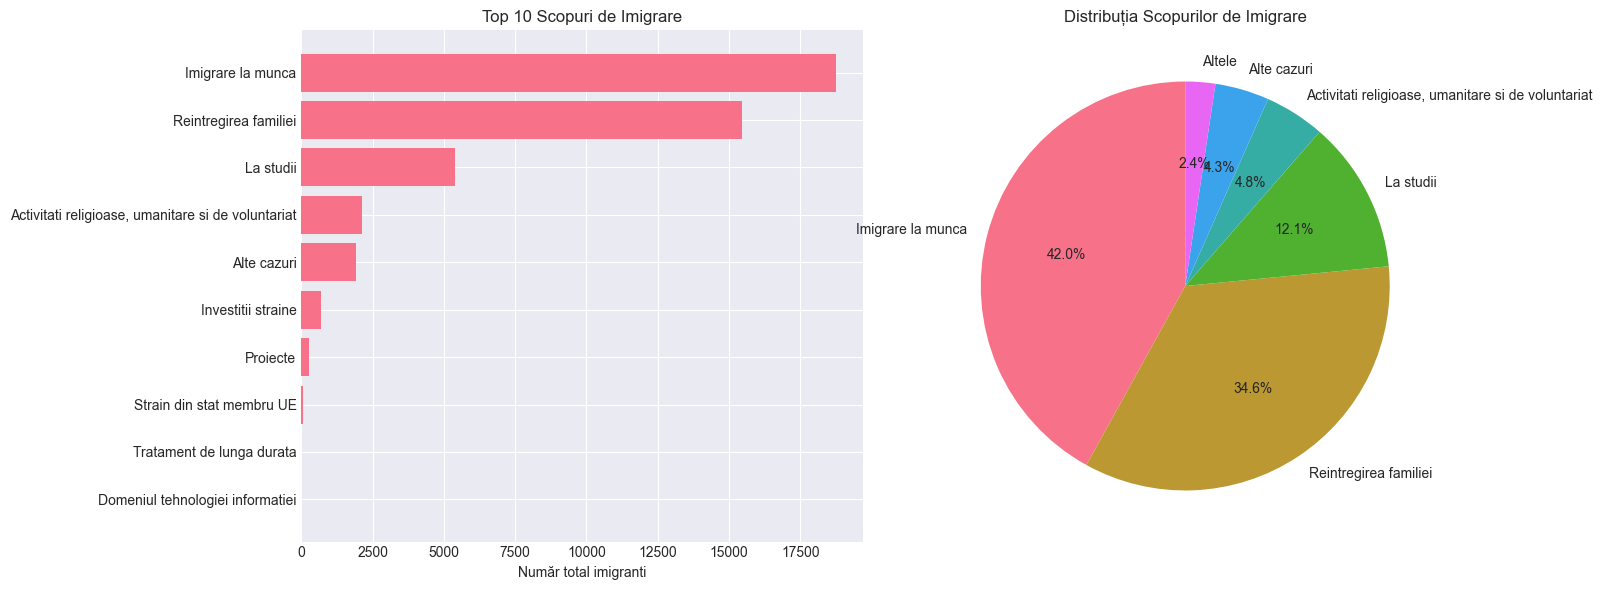

In [29]:
# Analiza scopurilor de imigrare

scopuri = df_complet_completat.groupby('Scop')['Numar'].agg(['sum', 'count', 'mean']).sort_values('sum', ascending=False)
scopuri['procent'] = (scopuri['sum'] / scopuri['sum'].sum() * 100).round(2)

print(f"\nTotal scopuri: {len(scopuri)}")
print("\nDistribuție pe scopuri:")
for i, (scop, row) in enumerate(scopuri.iterrows(), 1):
    print(f"{i:2d}. {scop:45s} | Total: {row['sum']:7,} | Procent: {row['procent']:5.1f}%")

# Vizualizare
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Top 10 scopuri
top10_scopuri = scopuri.head(10)
ax1.barh(range(len(top10_scopuri)), top10_scopuri['sum'])
ax1.set_yticks(range(len(top10_scopuri)))
ax1.set_yticklabels(top10_scopuri.index)
ax1.set_xlabel('Număr total imigranti')
ax1.set_title('Top 10 Scopuri de Imigrare')
ax1.invert_yaxis()

# Pie chart pentru top 5 + rest
top5 = scopuri.head(5)
rest = scopuri.iloc[5:]['sum'].sum()
sizes = list(top5['sum']) + [rest]
labels = list(top5.index) + ['Altele']

ax2.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
ax2.set_title('Distribuția Scopurilor de Imigrare')

plt.tight_layout()
plt.show()





Total țări: 172

Top 15 țări:
 1. FEDERATIA RUSA                   7,532 ( 17.3%)
 2. UCRAINA                          7,176 ( 16.5%)
 3. TURCIA                           5,986 ( 13.7%)
 4. ROMANIA                          3,319 (  7.6%)
 5. UZBEKISTAN                       2,433 (  5.6%)
 6. INDIA                            2,431 (  5.6%)
 7. ISRAEL                           1,380 (  3.2%)
 8. AZERBAIDJAN                      1,376 (  3.2%)
 9. NEPAL                            1,125 (  2.6%)
10. ITALIA                             909 (  2.1%)
11. SUA                                711 (  1.6%)
12. BANGLADESH                         512 (  1.2%)
13. TADJIKISTAN                        475 (  1.1%)
14. BELARUS                            456 (  1.0%)
15. STATELE UNITE                      426 (  1.0%)


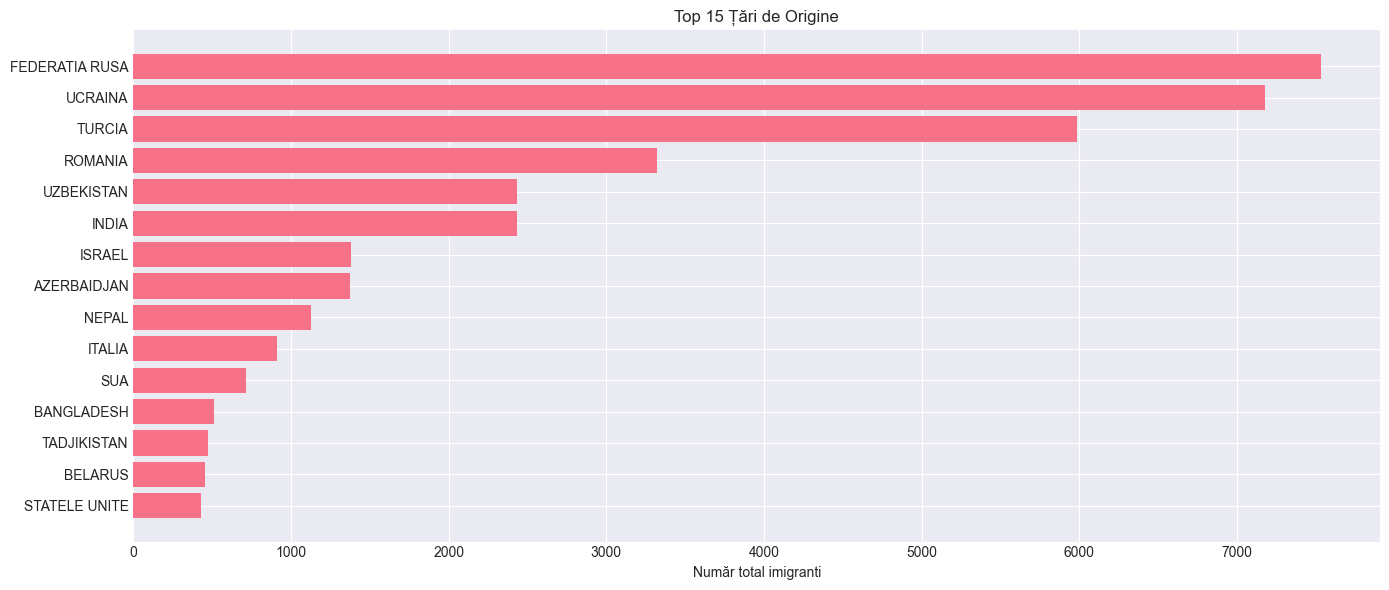

In [9]:
# Analiza țărilor de origine


tari = df_complet_completat.groupby('Tara')['Numar'].sum().sort_values(ascending=False)
print(f"\nTotal țări: {len(tari)}")
print("\nTop 15 țări:")
for i, (tara, count) in enumerate(tari.head(15).items(), 1):
    procent = (count / tari.sum() * 100)
    print(f"{i:2d}. {tara:30s} {count:7,} ({procent:5.1f}%)")

# Vizualizare
plt.figure(figsize=(14, 6))
top15_tari = tari.head(15)
plt.barh(range(len(top15_tari)), top15_tari.values)
plt.yticks(range(len(top15_tari)), top15_tari.index)
plt.xlabel('Număr total imigranti')
plt.title('Top 15 Țări de Origine')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


Statistici lunare:
  Media: 463 imigranti/lună
  Mediana: 449 imigranti/lună
  Min: 74 (2020-04)
  Max: 1,054 (2018-02)


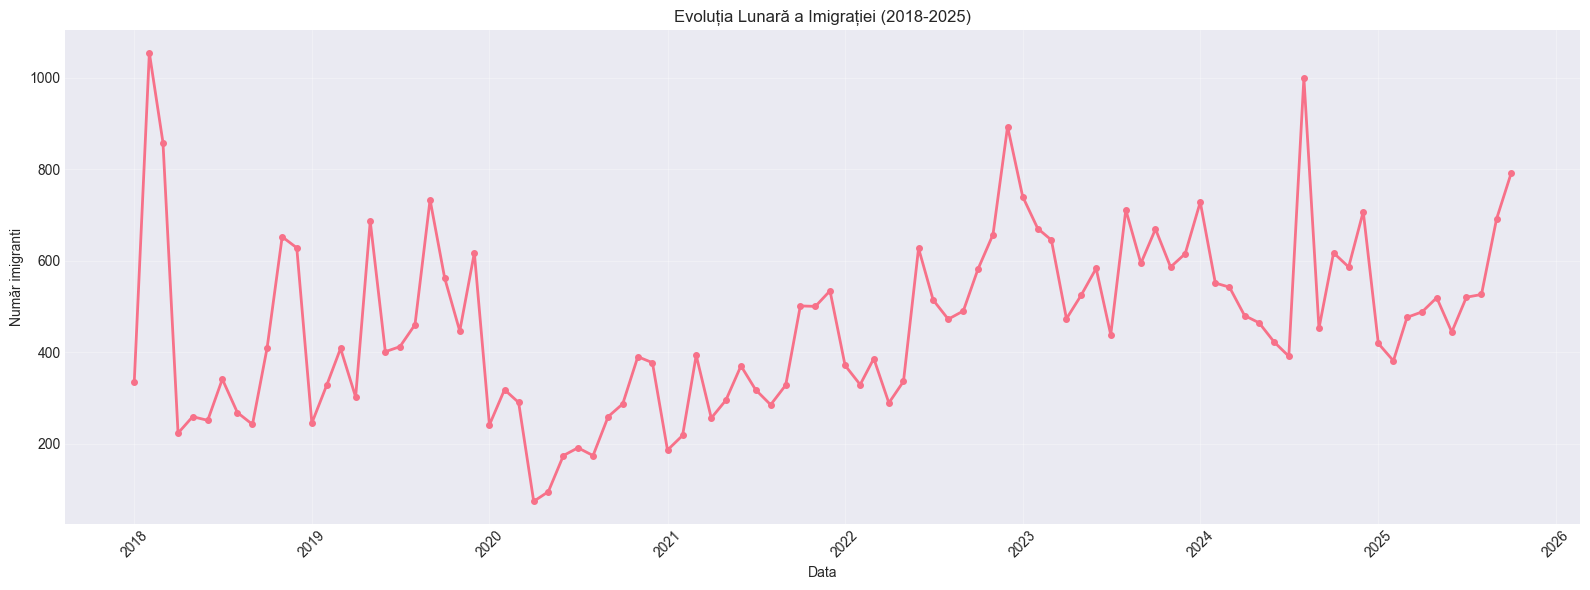

In [11]:
# Analiza temporală

# Agregare pe lună
#monthly = df_complet.groupby(['An', 'Luna'])['Numar'].sum().reset_index()

monthly = df_complet_completat.groupby(['An', 'Luna'])['Numar'].sum().reset_index()
monthly['Data'] = pd.to_datetime(monthly['An'].astype(str) + '-' + monthly['Luna'].astype(str) + '-01')
monthly = monthly.sort_values('Data')

print("\nStatistici lunare:")
print(f"  Media: {monthly['Numar'].mean():,.0f} imigranti/lună")
print(f"  Mediana: {monthly['Numar'].median():,.0f} imigranti/lună")
print(f"  Min: {monthly['Numar'].min():,} ({monthly.loc[monthly['Numar'].idxmin(), 'Data'].strftime('%Y-%m')})")
print(f"  Max: {monthly['Numar'].max():,} ({monthly.loc[monthly['Numar'].idxmax(), 'Data'].strftime('%Y-%m')})")

# Vizualizare trend
plt.figure(figsize=(16, 6))
plt.plot(monthly['Data'], monthly['Numar'], marker='o', linewidth=2, markersize=4)
plt.xlabel('Data')
plt.ylabel('Număr imigranti')
plt.title('Evoluția Lunară a Imigrației (2018-2025)')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Media pe luni:
  Ian:      5 (total:   3,265)
  Feb:      6 (total:   3,850)
  Mar:      6 (total:   3,998)
  Apr:      4 (total:   2,853)
  Mai:      6 (total:   3,178)
  Iun:      6 (total:   3,272)
  Iul:      5 (total:   3,392)
  Aug:      5 (total:   4,195)
  Sep:      6 (total:   3,789)
  Oct:      6 (total:   4,417)
  Noi:      6 (total:   3,817)
  Dec:      7 (total:   4,371)


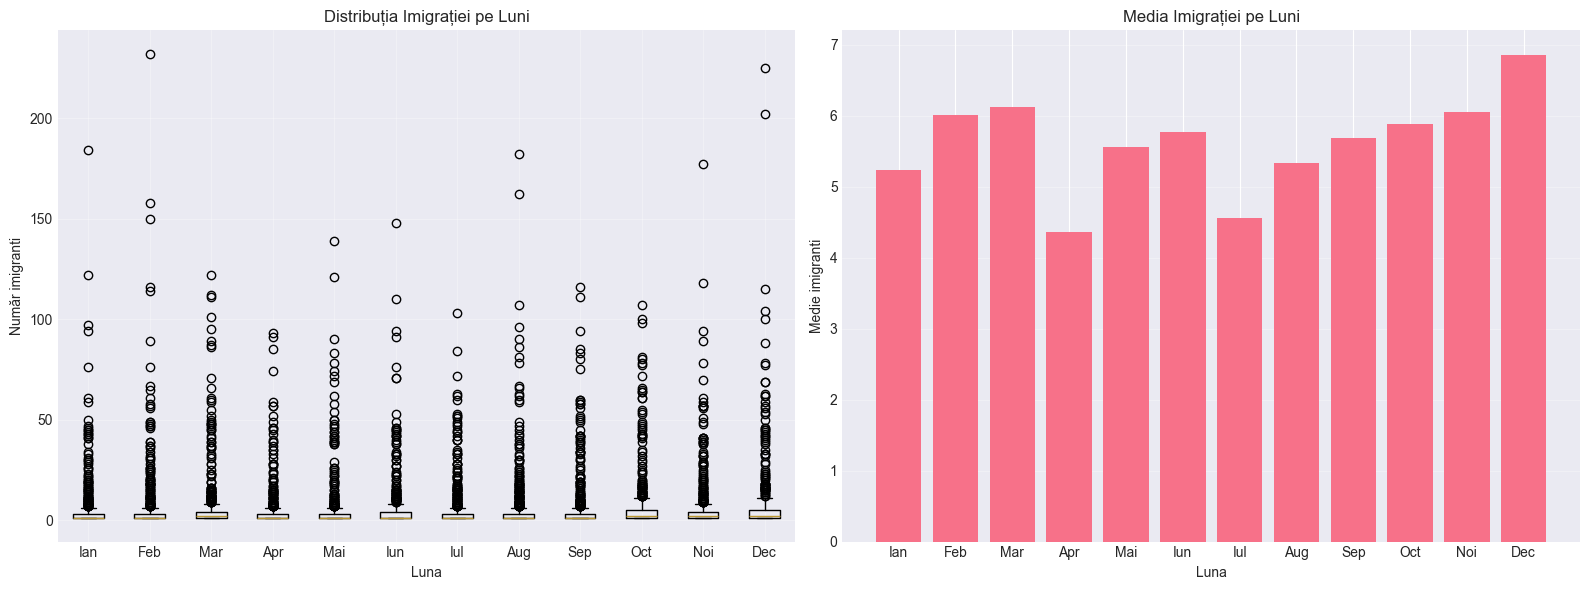

In [44]:
# Analiza sezonalității

# Media pe fiecare lună a anului
seasonal = df_complet_completat.groupby('Luna')['Numar'].agg(['sum', 'mean', 'count']).reset_index()
seasonal['Luna_Nume'] = seasonal['Luna'].map({
    1: 'Ian', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'Mai', 6: 'Iun',
    7: 'Iul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Noi', 12: 'Dec'
})

print("\nMedia pe luni:")
for _, row in seasonal.iterrows():
    print(f"  {row['Luna_Nume']:3s}: {row['mean']:6,.0f} (total: {row['sum']:7,})")

# Vizualizare
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Box plot
monthly_data = []
for luna in range(1, 13):
    data_luna = df_complet_completat[df_complet_completat['Luna'] == luna]['Numar'].values
    if len(data_luna) > 0:
        monthly_data.append(data_luna)
    else:
        monthly_data.append([0])

ax1.boxplot(monthly_data, labels=seasonal['Luna_Nume'])
ax1.set_xlabel('Luna')
ax1.set_ylabel('Număr imigranti')
ax1.set_title('Distribuția Imigrației pe Luni')
ax1.grid(True, alpha=0.3)

# Bar chart
ax2.bar(seasonal['Luna_Nume'], seasonal['mean'])
ax2.set_xlabel('Luna')
ax2.set_ylabel('Medie imigranti')
ax2.set_title('Media Imigrației pe Luni')
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('sezonalitate.png', dpi=300, bbox_inches='tight')
plt.show()

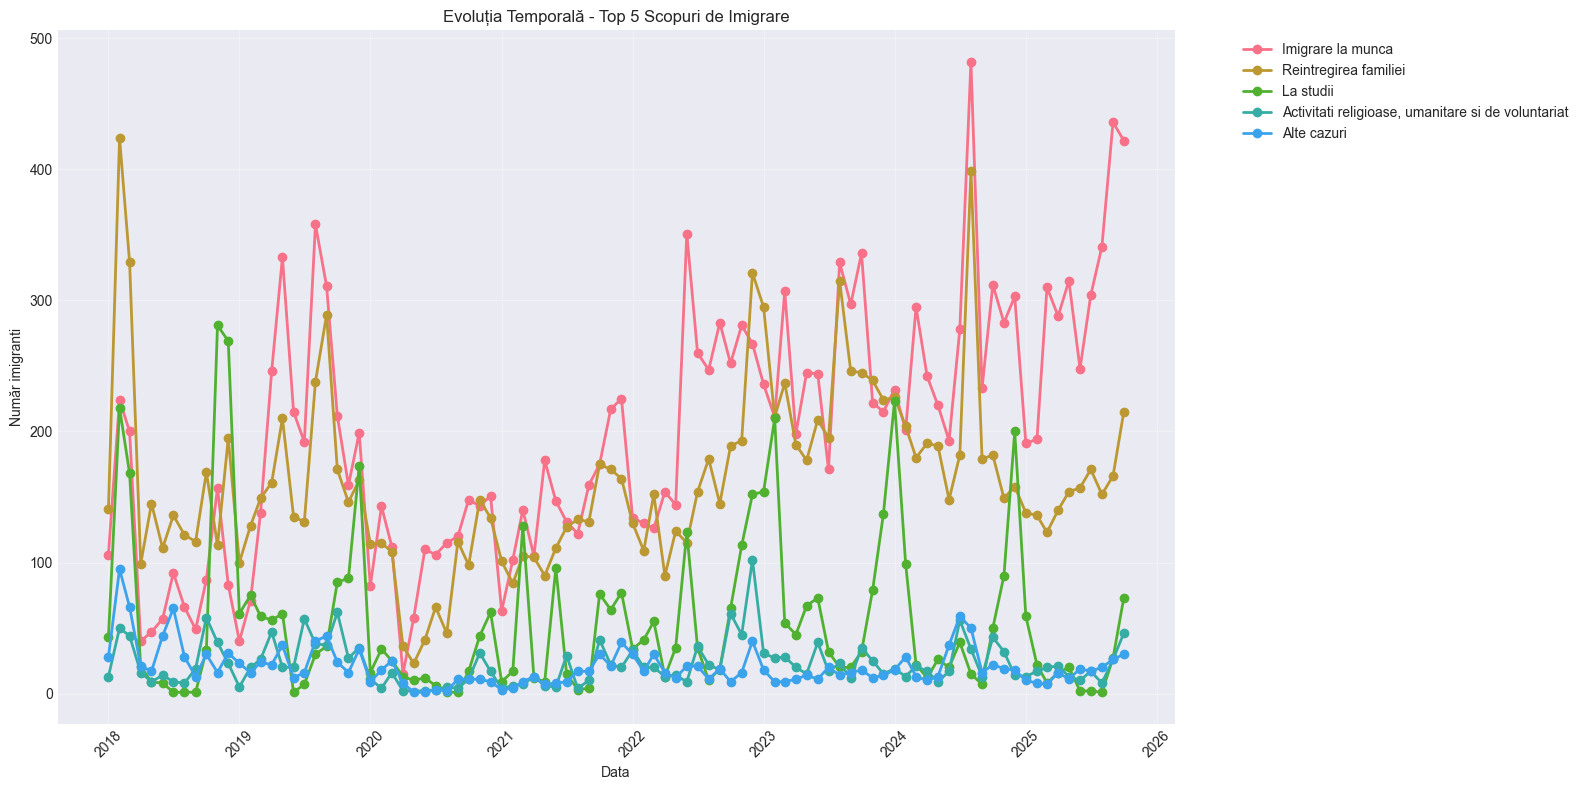

In [45]:
# Analiza evoluției pe scopuri principale

# Selectează top 5 scopuri
top5_scopuri = df_complet_completat.groupby('Scop')['Numar'].sum().nlargest(5).index

# Creează serie temporală pentru fiecare
plt.figure(figsize=(16, 8))

for scop in top5_scopuri:
    df_scop = df_complet_completat[df_complet_completat['Scop'] == scop].copy()
    df_scop_monthly = df_scop.groupby(['An', 'Luna'])['Numar'].sum().reset_index()
    df_scop_monthly['Data'] = pd.to_datetime(
        df_scop_monthly['An'].astype(str) + '-' + df_scop_monthly['Luna'].astype(str) + '-01'
    )
    df_scop_monthly = df_scop_monthly.sort_values('Data')
    
    plt.plot(df_scop_monthly['Data'], df_scop_monthly['Numar'], marker='o', label=scop, linewidth=2)

plt.xlabel('Data')
plt.ylabel('Număr imigranti')
plt.title('Evoluția Temporală - Top 5 Scopuri de Imigrare')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('evolutie_scopuri.png', dpi=300, bbox_inches='tight')
plt.show()

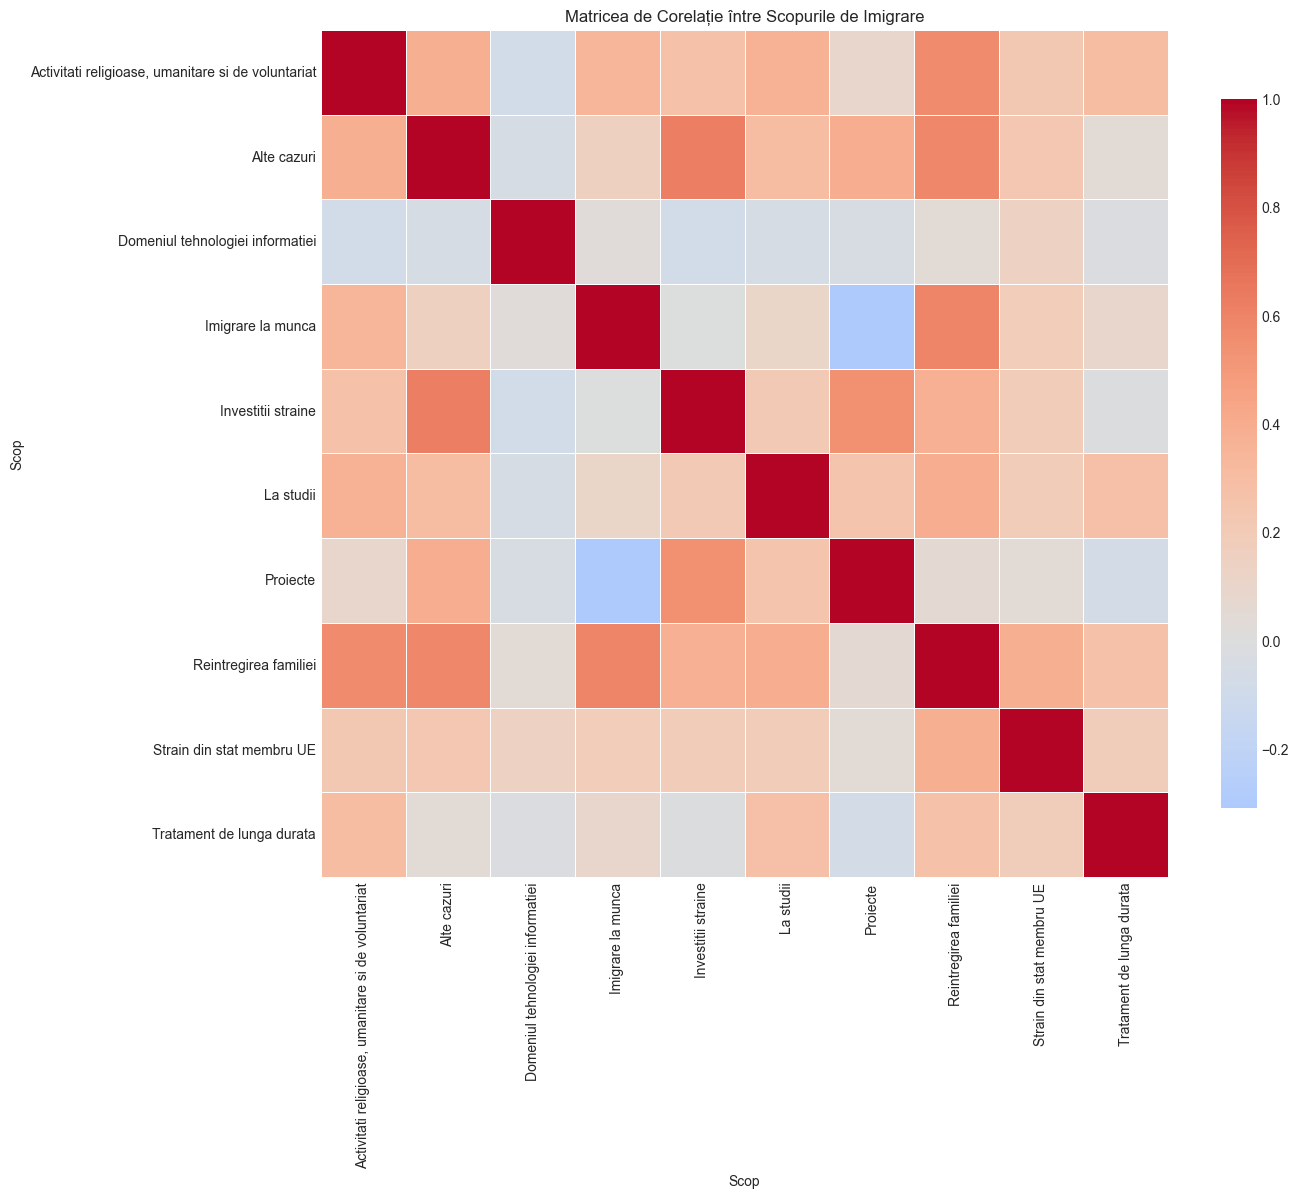

Alte cazuri                    <-> Investitii straine             :  0.619
Imigrare la munca              <-> Reintregirea familiei          :  0.594
Alte cazuri                    <-> Reintregirea familiei          :  0.580
Activitati religioase, umanita <-> Reintregirea familiei          :  0.564
Investitii straine             <-> Proiecte                       :  0.544


In [46]:
# Matrice de corelație între scopuri

# Creează dataset wide (scopuri ca coloane)
df_wide = df_agregat.pivot_table(
    index=['An', 'Luna'],
    columns='Scop',
    values='Numar',
    fill_value=0
)

# Calculează corelații
correlation = df_wide.corr()

# Vizualizare
plt.figure(figsize=(14, 12))
sns.heatmap(correlation, annot=False, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Matricea de Corelație între Scopurile de Imigrare')
plt.tight_layout()
plt.show()


# Afișează cele mai puternice corelații
corr_pairs = []
for i in range(len(correlation.columns)):
    for j in range(i+1, len(correlation.columns)):
        corr_val = correlation.iloc[i, j]
        if abs(corr_val) > 0.5:
            corr_pairs.append((correlation.columns[i], correlation.columns[j], corr_val))

corr_pairs.sort(key=lambda x: abs(x[2]), reverse=True)

if corr_pairs:
    for scop1, scop2, corr in corr_pairs:
        print(f"{scop1[:30]:30s} <-> {scop2[:30]:30s} : {corr:6.3f}")
else:
    print("Nu există corelații puternice între scopuri")


In [30]:
print("\nAdăugare coloană 'Data'...")

df_complet_completat['Data'] = pd.to_datetime(
    df_complet_completat['An'].astype(str) + '-' + 
    df_complet_completat['Luna'].astype(str) + '-01'
)

df_agregat_completat['Data'] = pd.to_datetime(
    df_agregat_completat['An'].astype(str) + '-' + 
    df_agregat_completat['Luna'].astype(str) + '-01'
)

print("Coloana 'Data' adăugată pentru ambele dataset-uri")

print(f"\nDataset Complet:")
print(f"   Perioada: {df_complet_completat['Data'].min().strftime('%Y-%m')} → {df_complet_completat['Data'].max().strftime('%Y-%m')}")
print(f"   Înregistrări: {len(df_complet_completat):,}")

print(f"\nDataset Agregat:")
print(f"   Perioada: {df_agregat_completat['Data'].min().strftime('%Y-%m')} → {df_agregat_completat['Data'].max().strftime('%Y-%m')}")
print(f"   Înregistrări: {len(df_agregat_completat):,}")



Adăugare coloană 'Data'...
Coloana 'Data' adăugată pentru ambele dataset-uri

Dataset Complet:
   Perioada: 2018-01 → 2025-12
   Înregistrări: 83,247

Dataset Agregat:
   Perioada: 2018-01 → 2025-12
   Înregistrări: 1,037


In [39]:
#Adaugă features temporale pentru sezonalitate
def add_time_features(df):
    df = df.copy()
    
    # Transformare ciclică a lunii
    df['Luna_Sin'] = np.sin(2 * np.pi * df['Luna'] / 12)
    df['Luna_Cos'] = np.cos(2 * np.pi * df['Luna'] / 12)
    
    # Trimestru
    df['Trimestru'] = ((df['Luna'] - 1) // 3 + 1).astype(int)
    
    # Sezon: 1-Iarna, 2-Primavara, 3-Vara, 4-Toamna
    sezon_map = {
        1: 1, 2: 1,          # Iarna (Ian, Feb)
        3: 2, 4: 2, 5: 2,    # Primăvara (Mar, Apr, Mai)
        6: 3, 7: 3, 8: 3,    # Vara (Iun, Iul, Aug)
        9: 4, 10: 4, 11: 4,  # Toamna (Sep, Oct, Noi)
        12: 1                # Iarna (Dec)
    }
    df['Sezon'] = df['Luna'].map(sezon_map).astype(int)
    
    # Indicator pentru ianuarie
    df['Este_Ianuarie'] = (df['Luna'] == 1).astype(int)
    
    return df

In [32]:
#Adaugă caracteristici de întârziere - valori din lunile anterioare
def add_lag_features(df):
    df = df.sort_values(['Scop', 'An', 'Luna']).copy()
    
    # Lag features: 1, 2, 3, 12 luni
    for lag in [1, 2, 3, 12]:
        df[f'Lag_{lag}'] = df.groupby(['Scop'])['Numar'].shift(lag)
    
    # Media mobilă pe 3 luni
    df['Rolling_Mean_3'] = (
        df.groupby(['Scop'])['Numar']
        .shift(1)  # Nu include luna curentă
        .rolling(window=3, min_periods=1)
        .mean()
    )
    
    # Deviatia standard mobilă pe 3 luni
    df['Rolling_Std_3'] = (
        df.groupby(['Scop'])['Numar']
        .shift(1)
        .rolling(window=3, min_periods=1)
        .std()
        .fillna(0)
    )
    
    return df

In [33]:
# Adaugă caracteristici pentru capturarea tendințelor
def add_trend_features(df):
    df = df.copy()
    
    # Număr de luni de la început
    df['Months_Since_Start'] = df.groupby(['Scop']).cumcount()
    
    # An + Luna normalizat
    df['Year_Month'] = df['An'] + df['Luna'] / 12
    
    return df

In [34]:
#Codează variabilele categoriale
def encode_categorical(df):
    df = df.copy()
    
    # Encodează Scop
    le_scop = LabelEncoder()
    df['Scop_Encoded'] = le_scop.fit_transform(df['Scop'])
    
    return df, le_scop

In [36]:
def clean_incomplete_data(df):
    initial_count = len(df)
    
    # Elimină rândurile unde lipsesc lag features critice
    critical_lags = ['Lag_1', 'Lag_12', 'Rolling_Mean_3']
    df_clean = df.dropna(subset=critical_lags).copy()
    
    removed_count = initial_count - len(df_clean)
    
    print(f"\n   Înainte: {initial_count:,} rânduri")
    print(f"   După:    {len(df_clean):,} rânduri")
    print(f"   Eliminate: {removed_count:,} rânduri cu date incomplete")
    
    return df_clean.reset_index(drop=True)

In [35]:
def prepare_ml_dataset(df):
    feature_columns = [
        'Data',
        'An', 'Luna', 'Scop',
        'Scop_Encoded',
        'Numar',
        'Luna_Sin', 'Luna_Cos', 'Trimestru', 'Sezon', 'Este_Ianuarie',
        'Months_Since_Start', 'Year_Month',
        'Lag_1', 'Lag_2', 'Lag_3', 'Lag_12',
        'Rolling_Mean_3', 'Rolling_Std_3'
    ]
    
    return df[feature_columns].copy()


In [43]:

print("\n Adăugare features temporale...")
df_ml = add_time_features(df_agregat_completat)
print(f"   Adăugate: Luna_Sin, Luna_Cos, Trimestru, Sezon, Este_Ianuarie")

print("\n Adăugare trend features...")
df_ml = add_trend_features(df_ml)
print(f"   Adăugate: Months_Since_Start, Year_Month")

print("\n Adăugare lag features...")
df_ml = add_lag_features(df_ml)
print(f"   Adăugate: Lag_1, Lag_2, Lag_3, Lag_12, Rolling_Mean_3, Rolling_Std_3")

print("\n  Encoding categorial...")
df_ml, le_scop = encode_categorical(df_ml)
print(f"   Scop -> Scop_Encoded ({len(le_scop.classes_)} categorii)")
print(f"   Categorii: {', '.join(le_scop.classes_)}")

print("\n  Pregătire și curățare dataset...")
df_ml = prepare_ml_dataset(df_ml)
df_ml = clean_incomplete_data(df_ml)


 Adăugare features temporale...
   Adăugate: Luna_Sin, Luna_Cos, Trimestru, Sezon, Este_Ianuarie

 Adăugare trend features...
   Adăugate: Months_Since_Start, Year_Month

 Adăugare lag features...
   Adăugate: Lag_1, Lag_2, Lag_3, Lag_12, Rolling_Mean_3, Rolling_Std_3

  Encoding categorial...
   Scop -> Scop_Encoded (12 categorii)
   Categorii: Activitati religioase, umanitare si de voluntariat, Alte cazuri, Domeniul tehnologiei informatiei, Imigrare la munca, Investitii straine, La studii, Nomad digital, Proiecte, Protectie victime, Reintregirea familiei, Strain din stat membru UE, Tratament de lunga durata

  Pregătire și curățare dataset...

   Înainte: 1,037 rânduri
   După:    903 rânduri
   Eliminate: 134 rânduri cu date incomplete


In [45]:
# Verificare rapidă

print("\nInfo:")
print(df_ml.info())

print("\n Primele 5 rânduri:")
display(df_ml.head(5))

print("\n Eșantion aleatoriu (5 rânduri):")
display(df_ml.sample(5, random_state=42))

print("\n Distribuție pe scopuri:")
print(df_ml['Scop'].value_counts())

print("\n Verificare valori null:")
print(df_ml.isnull().sum())


Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903 entries, 0 to 902
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Data                903 non-null    datetime64[ns]
 1   An                  903 non-null    int64         
 2   Luna                903 non-null    int64         
 3   Scop                903 non-null    object        
 4   Scop_Encoded        903 non-null    int64         
 5   Numar               903 non-null    int64         
 6   Luna_Sin            903 non-null    float64       
 7   Luna_Cos            903 non-null    float64       
 8   Trimestru           903 non-null    int64         
 9   Sezon               903 non-null    int64         
 10  Este_Ianuarie       903 non-null    int64         
 11  Months_Since_Start  903 non-null    int64         
 12  Year_Month          903 non-null    float64       
 13  Lag_1               903 non-null    float64

,Data,An,Luna,Scop,Scop_Encoded,Numar,Luna_Sin,Luna_Cos,Trimestru,Sezon,Este_Ianuarie,Months_Since_Start,Year_Month,Lag_1,Lag_2,Lag_3,Lag_12,Rolling_Mean_3,Rolling_Std_3
0,2019-01-01,2019,1,"Activitati religioase, umanitare si de volunta...",0,5,0.500000,8.660254e-01,1,1,1,12,2019.083333,23.0,39.0,58.0,13.0,40.000000,17.521415
1,2019-02-01,2019,2,"Activitati religioase, umanitare si de volunta...",0,20,0.866025,5.000000e-01,1,1,0,13,2019.166667,5.0,23.0,39.0,50.0,22.333333,17.009801
2,2019-03-01,2019,3,"Activitati religioase, umanitare si de volunta...",0,26,1.000000,6.123234e-17,1,2,0,14,2019.250000,20.0,5.0,23.0,44.0,16.000000,9.643651
3,2019-04-01,2019,4,"Activitati religioase, umanitare si de volunta...",0,14,0.866025,-5.000000e-01,2,2,0,15,2019.333333,26.0,20.0,5.0,16.0,17.000000,10.816654
4,2019-05-01,2019,5,"Activitati religioase, umanitare si de volunta...",0,20,0.500000,-8.660254e-01,2,2,0,16,2019.416667,14.0,26.0,20.0,9.0,20.000000,6.000000



 Eșantion aleatoriu (5 rânduri):


,Data,An,Luna,Scop,Scop_Encoded,Numar,Luna_Sin,Luna_Cos,Trimestru,Sezon,Este_Ianuarie,Months_Since_Start,Year_Month,Lag_1,Lag_2,Lag_3,Lag_12,Rolling_Mean_3,Rolling_Std_3
70,2024-11-01,2024,11,"Activitati religioase, umanitare si de volunta...",0,32,-0.500000,8.660254e-01,4,4,0,82,2024.916667,43.0,13.0,34.0,25.0,30.000000,15.394804
457,2022-11-01,2022,11,La studii,5,113,-0.500000,8.660254e-01,4,4,0,58,2022.916667,65.0,19.0,10.0,64.0,31.333333,29.501412
218,2023-09-01,2023,9,Domeniul tehnologiei informatiei,2,0,-1.000000,-1.836970e-16,3,4,0,62,2023.750000,0.0,0.0,0.0,0.0,0.000000,0.000000
250,2019-08-01,2019,8,Imigrare la munca,3,243,-0.866025,-5.000000e-01,3,3,0,19,2019.666667,192.0,215.0,333.0,66.0,246.666667,75.646106
39,2022-04-01,2022,4,"Activitati religioase, umanitare si de volunta...",0,13,0.866025,-5.000000e-01,2,2,0,51,2022.333333,20.0,20.0,33.0,13.0,24.333333,7.505553



 Distribuție pe scopuri:
Scop
Activitati religioase, umanitare si de voluntariat    84
Alte cazuri                                           84
Imigrare la munca                                     84
Reintregirea familiei                                 84
Investitii straine                                    84
La studii                                             84
Proiecte                                              84
Strain din stat membru UE                             82
Protectie victime                                     79
Tratament de lunga durata                             79
Domeniul tehnologiei informatiei                      75
Name: count, dtype: int64

 Verificare valori null:
Data                  0
An                    0
Luna                  0
Scop                  0
Scop_Encoded          0
Numar                 0
Luna_Sin              0
Luna_Cos              0
Trimestru             0
Sezon                 0
Este_Ianuarie         0
Months_Since_Start    0
Ye

In [46]:
print(" SALVARE REZULTATE")

# 1. Salvează dataset COMPLET (cu țări) completat
df_complet_completat.to_excel("date_lunare_completate.xlsx", index=False)
print(f"\n Salvat: date_lunare_completate.xlsx")
print(f"   → {len(df_complet_completat):,} înregistrări")
print(f"   → Cu date completate pentru lunile lipsă")
print(f"   → Include toate țările și scopurile")

# 2. Salvează dataset AGREGAT completat (fără țări)
df_agregat_completat.to_excel("date_agregat_completate.xlsx", index=False)
print(f"\n Salvat: date_agregat_completate.xlsx")
print(f"   → {len(df_agregat_completat):,} înregistrări")
print(f"   → Fără țări (agregat pe scopuri)")
print(f"   → Cu date completate pentru lunile lipsă")

# 3. Salvează datele preprocesate pentru ML (din dataset agregat)
df_ml.to_excel("date_preprocesate_ml.xlsx", index=False)
print(f"\n Salvat: date_preprocesate_ml.xlsx")
print(f"   → {len(df_ml):,} înregistrări")
print(f"   → Cu toate features pentru ML")
print(f"   → Bazat pe dataset agregat completat")
print(f"   → ACESTA VA FI FOLOSIT PENTRU ANTRENAMENT")

# 4. Salvează encoderele
encoders = {'scop': le_scop}
with open('label_encoders.pkl', 'wb') as f:
    pickle.dump(encoders, f)
print(f"\n Salvat: label_encoders.pkl")
print(f"   → Encodere pentru predicții viitoare")

 SALVARE REZULTATE

 Salvat: date_lunare_completate.xlsx
   → 83,247 înregistrări
   → Cu date completate pentru lunile lipsă
   → Include toate țările și scopurile

 Salvat: date_agregat_completate.xlsx
   → 1,037 înregistrări
   → Fără țări (agregat pe scopuri)
   → Cu date completate pentru lunile lipsă

 Salvat: date_preprocesate_ml.xlsx
   → 903 înregistrări
   → Cu toate features pentru ML
   → Bazat pe dataset agregat completat
   → ACESTA VA FI FOLOSIT PENTRU ANTRENAMENT

 Salvat: label_encoders.pkl
   → Encodere pentru predicții viitoare
